In [1]:
import numpy as np
import pandas as pd
import xlrd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from path import Path
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor() 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
df = pd.read_csv("../modified_data/pol_svi_sc_merged.csv")
df.head()

,FIPS,3/31/21,AREA_SQMI,E_TOTPOP,E_HU,E_HH,E_POV,E_UNEMP,E_PCI,E_NOHSDP,...,Hopefulness,Income Per Capita,Neuroticism,Openness,Religiosity,Risk Taking,Selflessness,Tolerance,Work Ethic,dem_pct
0,1001,6589,594.443459,55200.0,23315.0,21115.0,8422.0,1065.0,29372.0,4204.0,...,91.163142,26168.0,77.925476,78.222354,91.106719,53.333333,82.142857,70.000000,60.380952,27.018365
1,1003,20505,1589.793007,208107.0,111945.0,78622.0,21653.0,4343.0,31203.0,14310.0,...,82.484017,28069.0,77.232120,80.086368,71.771566,67.272980,75.586018,66.983549,70.972246,22.409030
2,1005,2227,885.001636,25782.0,11937.0,9186.0,6597.0,918.0,18461.0,4901.0,...,61.927181,17249.0,80.375206,78.783778,73.657368,76.066481,78.753019,65.170377,68.704105,45.788173
3,1007,2542,622.461089,22527.0,9161.0,6840.0,2863.0,658.0,20199.0,2650.0,...,85.258871,18988.0,80.813736,77.837027,69.974652,75.136154,76.929754,69.859503,67.931677,20.698280
4,1009,6444,644.830460,57645.0,24222.0,20600.0,8220.0,909.0,22656.0,7861.0,...,79.492703,21033.0,78.764620,78.193105,92.045455,57.603815,79.307632,64.953288,76.000000,9.569378


In [3]:
#set index to FIPS
df = df.set_index(df['FIPS'])
df= df.drop('FIPS', axis=1)

In [4]:
#rename target column
df = df.rename(columns={'3/31/21':'first_year_cases'})

In [5]:
#create variable for case% for each counties population
df['case_pct'] = df['first_year_cases']/df['E_TOTPOP']*100
df['case_pct'].head()

FIPS
1001    11.936594
1003     9.853104
1005     8.637809
1007    11.284237
1009    11.178767
Name: case_pct, dtype: float64

In [6]:
df['case_pct'].describe()

count    3058.000000
mean        9.426600
std         3.045809
min         0.000000
25%         7.713422
50%         9.466675
75%        11.176131
max        38.010657
Name: case_pct, dtype: float64

In [7]:
# bin and cut the case_pct column into 2 classifications
# q = df['case_pct'].quantile(.75)
q = df['case_pct'].quantile(.9)
bins = [0, q , 40]
labels = ['low','high']
df['case_class'] = pd.cut(df['case_pct'], bins, labels = labels)
df['case_class']

FIPS
1001      low
1003      low
1005      low
1007      low
1009      low
         ... 
56037     low
56039    high
56041     low
56043     low
56045     low
Name: case_class, Length: 3058, dtype: category
Categories (2, object): ['low' < 'high']

In [8]:
df['case_class'].value_counts()

low     2728
high     306
Name: case_class, dtype: int64

In [9]:
#drop unneeded columns
df = df.drop('case_pct', axis =1)
df

,first_year_cases,AREA_SQMI,E_TOTPOP,E_HU,E_HH,E_POV,E_UNEMP,E_PCI,E_NOHSDP,E_AGE65,...,Income Per Capita,Neuroticism,Openness,Religiosity,Risk Taking,Selflessness,Tolerance,Work Ethic,dem_pct,case_class
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,6589,594.443459,55200.0,23315.0,21115.0,8422.0,1065.0,29372.0,4204.0,8050.0,...,26168.0,77.925476,78.222354,91.106719,53.333333,82.142857,70.000000,60.380952,27.018365,low
1003,20505,1589.793007,208107.0,111945.0,78622.0,21653.0,4343.0,31203.0,14310.0,40665.0,...,28069.0,77.232120,80.086368,71.771566,67.272980,75.586018,66.983549,70.972246,22.409030,low
1005,2227,885.001636,25782.0,11937.0,9186.0,6597.0,918.0,18461.0,4901.0,4634.0,...,17249.0,80.375206,78.783778,73.657368,76.066481,78.753019,65.170377,68.704105,45.788173,low
1007,2542,622.461089,22527.0,9161.0,6840.0,2863.0,658.0,20199.0,2650.0,3661.0,...,18988.0,80.813736,77.837027,69.974652,75.136154,76.929754,69.859503,67.931677,20.698280,low
1009,6444,644.830460,57645.0,24222.0,20600.0,8220.0,909.0,22656.0,7861.0,10233.0,...,21033.0,78.764620,78.193105,92.045455,57.603815,79.307632,64.953288,76.000000,9.569378,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,4022,10426.975725,44117.0,19628.0,15871.0,5237.0,1213.0,32624.0,2549.0,4721.0,...,30945.0,79.384759,79.347081,68.147062,73.938691,76.390464,67.420658,70.956334,22.894957,low
56039,3609,3996.844622,23059.0,13680.0,9158.0,1619.0,210.0,53703.0,958.0,3135.0,...,46499.0,71.547359,80.522872,65.399695,79.598153,79.698193,70.877600,70.938645,66.599040,high
56041,2128,2081.719807,20609.0,8972.0,7735.0,2552.0,614.0,27009.0,934.0,2498.0,...,25636.0,78.771570,77.859042,67.603416,69.705859,73.332067,67.404487,69.299391,16.819960,low


In [10]:
#drop unneeded columns
df = df.drop('first_year_cases', axis =1)
df

,AREA_SQMI,E_TOTPOP,E_HU,E_HH,E_POV,E_UNEMP,E_PCI,E_NOHSDP,E_AGE65,E_AGE17,...,Income Per Capita,Neuroticism,Openness,Religiosity,Risk Taking,Selflessness,Tolerance,Work Ethic,dem_pct,case_class
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,594.443459,55200.0,23315.0,21115.0,8422.0,1065.0,29372.0,4204.0,8050.0,13369.0,...,26168.0,77.925476,78.222354,91.106719,53.333333,82.142857,70.000000,60.380952,27.018365,low
1003,1589.793007,208107.0,111945.0,78622.0,21653.0,4343.0,31203.0,14310.0,40665.0,45677.0,...,28069.0,77.232120,80.086368,71.771566,67.272980,75.586018,66.983549,70.972246,22.409030,low
1005,885.001636,25782.0,11937.0,9186.0,6597.0,918.0,18461.0,4901.0,4634.0,5436.0,...,17249.0,80.375206,78.783778,73.657368,76.066481,78.753019,65.170377,68.704105,45.788173,low
1007,622.461089,22527.0,9161.0,6840.0,2863.0,658.0,20199.0,2650.0,3661.0,4659.0,...,18988.0,80.813736,77.837027,69.974652,75.136154,76.929754,69.859503,67.931677,20.698280,low
1009,644.830460,57645.0,24222.0,20600.0,8220.0,909.0,22656.0,7861.0,10233.0,13468.0,...,21033.0,78.764620,78.193105,92.045455,57.603815,79.307632,64.953288,76.000000,9.569378,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,10426.975725,44117.0,19628.0,15871.0,5237.0,1213.0,32624.0,2549.0,4721.0,11809.0,...,30945.0,79.384759,79.347081,68.147062,73.938691,76.390464,67.420658,70.956334,22.894957,low
56039,3996.844622,23059.0,13680.0,9158.0,1619.0,210.0,53703.0,958.0,3135.0,4434.0,...,46499.0,71.547359,80.522872,65.399695,79.598153,79.698193,70.877600,70.938645,66.599040,high
56041,2081.719807,20609.0,8972.0,7735.0,2552.0,614.0,27009.0,934.0,2498.0,6071.0,...,25636.0,78.771570,77.859042,67.603416,69.705859,73.332067,67.404487,69.299391,16.819960,low


In [11]:
#turn case % classifications into binary 
df = pd.get_dummies(df, columns = ['case_class'])
df

,AREA_SQMI,E_TOTPOP,E_HU,E_HH,E_POV,E_UNEMP,E_PCI,E_NOHSDP,E_AGE65,E_AGE17,...,Neuroticism,Openness,Religiosity,Risk Taking,Selflessness,Tolerance,Work Ethic,dem_pct,case_class_low,case_class_high
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,594.443459,55200.0,23315.0,21115.0,8422.0,1065.0,29372.0,4204.0,8050.0,13369.0,...,77.925476,78.222354,91.106719,53.333333,82.142857,70.000000,60.380952,27.018365,1,0
1003,1589.793007,208107.0,111945.0,78622.0,21653.0,4343.0,31203.0,14310.0,40665.0,45677.0,...,77.232120,80.086368,71.771566,67.272980,75.586018,66.983549,70.972246,22.409030,1,0
1005,885.001636,25782.0,11937.0,9186.0,6597.0,918.0,18461.0,4901.0,4634.0,5436.0,...,80.375206,78.783778,73.657368,76.066481,78.753019,65.170377,68.704105,45.788173,1,0
1007,622.461089,22527.0,9161.0,6840.0,2863.0,658.0,20199.0,2650.0,3661.0,4659.0,...,80.813736,77.837027,69.974652,75.136154,76.929754,69.859503,67.931677,20.698280,1,0
1009,644.830460,57645.0,24222.0,20600.0,8220.0,909.0,22656.0,7861.0,10233.0,13468.0,...,78.764620,78.193105,92.045455,57.603815,79.307632,64.953288,76.000000,9.569378,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,10426.975725,44117.0,19628.0,15871.0,5237.0,1213.0,32624.0,2549.0,4721.0,11809.0,...,79.384759,79.347081,68.147062,73.938691,76.390464,67.420658,70.956334,22.894957,1,0
56039,3996.844622,23059.0,13680.0,9158.0,1619.0,210.0,53703.0,958.0,3135.0,4434.0,...,71.547359,80.522872,65.399695,79.598153,79.698193,70.877600,70.938645,66.599040,0,1
56041,2081.719807,20609.0,8972.0,7735.0,2552.0,614.0,27009.0,934.0,2498.0,6071.0,...,78.771570,77.859042,67.603416,69.705859,73.332067,67.404487,69.299391,16.819960,1,0


## Decision Tree

In [12]:
# Define feature set
X = df.copy()
X = df.drop(['case_class_low','case_class_high'], axis=1).values

In [13]:
# Define the target set.
y=df['case_class_high'].values
y[:3058]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [14]:
#split data for training and testing 
# making training set 70% of data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=85)
X_train.shape, X_test.shape

((2446, 102), (612, 102))

In [15]:
# Determine the shape of our training and testing sets.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2446, 102)
(612, 102)
(2446,)
(612,)


In [16]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [17]:
# Creating the decision tree classifier instance.
model = tree.DecisionTreeClassifier()
# Fitting the model.
model = model.fit(X_train_scaled, y_train)

In [18]:
# Making predictions using the testing data.
predictions = model.predict(X_test_scaled)
predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [19]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,496,57
Actual 1,40,19


### Sensitivty ~.9158, Specificity ~.6512, PPV ~ .9315, NPV ~.7000, Accuracy ~.8627

In [20]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)

In [21]:
#(True Positives (TP) + True Negatives (TN)) 
Accuracy = (762 + 30)/918 
Accuracy

0.8627450980392157

In [22]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,496,57
Actual 1,40,19


Accuracy Score : 0.8415032679738562
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       553
           1       0.25      0.32      0.28        59

    accuracy                           0.84       612
   macro avg       0.59      0.61      0.60       612
weighted avg       0.86      0.84      0.85       612



In [23]:
# Calculate feature importance in the Random Forest model.
importances = model.feature_importances_
importances

array([0.03032528, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00300222, 0.02029003, 0.0110125 , 0.00975723,
       0.00225167, 0.00225167, 0.        , 0.00375278, 0.        ,
       0.00130181, 0.00686222, 0.005404  , 0.02947979, 0.        ,
       0.01687999, 0.01038444, 0.02629317, 0.        , 0.005404  ,
       0.00643571, 0.00425921, 0.0160507 , 0.01184875, 0.01736973,
       0.00502745, 0.00694264, 0.00242522, 0.00215343, 0.0177337 ,
       0.01323981, 0.00427817, 0.        , 0.02851483, 0.01461778,
       0.01157299, 0.00827175, 0.00376807, 0.00086185, 0.00617205,
       0.00394353, 0.00525389, 0.        , 0.01686142, 0.00199412,
       0.00611167, 0.02490977, 0.04129687, 0.00135591, 0.01412872,
       0.00801427, 0.        , 0.01570214, 0.00975723, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00225167, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [24]:
# We can sort the features by their importance.
X = df.drop(['case_class_low','case_class_high'], axis=1).columns
sorted(zip(model.feature_importances_, X), reverse=True)

[(0.04325404431270129, 'Employment Rate'),
 (0.0412968703045796, 'EPL_CROWD'),
 (0.04119593248218473, 'Tolerance'),
 (0.03979819495115467, 'Openness'),
 (0.037439013058691864, 'Entrepreneurship'),
 (0.03362287648702324, 'Collectivism'),
 (0.03122922357104226, 'dem_pct'),
 (0.030325276237022, 'AREA_SQMI'),
 (0.029479791915259925, 'E_GROUPQ'),
 (0.028514830916658743, 'SPL_THEME1'),
 (0.026293172971448123, 'EP_NOHSDP'),
 (0.025993336342846694, 'Conflict Awareness'),
 (0.024909765260263457, 'EPL_MOBILE'),
 (0.023816011679310935, 'Belief In Science'),
 (0.023647971075420646, 'Conscientiousness'),
 (0.02275485771402742, 'Selflessness'),
 (0.020290026730753367, 'E_NOHSDP'),
 (0.019654818457711234, 'Gender Equality'),
 (0.019148350845182103, 'Income Per Capita'),
 (0.01817547816782142, 'EP_UNINSUR'),
 (0.01773369961078633, 'EPL_POV'),
 (0.017714598507829058, 'Agreeableness'),
 (0.017369729628103035, 'EP_MUNIT'),
 (0.01735846792356009, 'Empathy'),
 (0.01687999006615624, 'EP_UNEMP'),
 (0.0168614

## RF Regressor

In [73]:
df.head(5)

,AREA_SQMI,E_TOTPOP,E_HU,E_HH,E_POV,E_UNEMP,E_PCI,E_NOHSDP,E_AGE65,E_AGE17,...,Neuroticism,Openness,Religiosity,Risk Taking,Selflessness,Tolerance,Work Ethic,dem_pct,case_class_low,case_class_high
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,594.443459,55200.0,23315.0,21115.0,8422.0,1065.0,29372.0,4204.0,8050.0,13369.0,...,77.925476,78.222354,91.106719,53.333333,82.142857,70.000000,60.380952,27.018365,1,0
1003,1589.793007,208107.0,111945.0,78622.0,21653.0,4343.0,31203.0,14310.0,40665.0,45677.0,...,77.232120,80.086368,71.771566,67.272980,75.586018,66.983549,70.972246,22.409030,1,0
1005,885.001636,25782.0,11937.0,9186.0,6597.0,918.0,18461.0,4901.0,4634.0,5436.0,...,80.375206,78.783778,73.657368,76.066481,78.753019,65.170377,68.704105,45.788173,1,0
1007,622.461089,22527.0,9161.0,6840.0,2863.0,658.0,20199.0,2650.0,3661.0,4659.0,...,80.813736,77.837027,69.974652,75.136154,76.929754,69.859503,67.931677,20.698280,1,0
1009,644.830460,57645.0,24222.0,20600.0,8220.0,909.0,22656.0,7861.0,10233.0,13468.0,...,78.764620,78.193105,92.045455,57.603815,79.307632,64.953288,76.000000,9.569378,1,0


In [74]:
df.shape

(3058, 104)

In [75]:
# Define feature set (x)
X = df.copy()
X = df.drop(['case_class_low','case_class_high'], axis=1).values

#Define (y)
y=df['case_class_high'].values

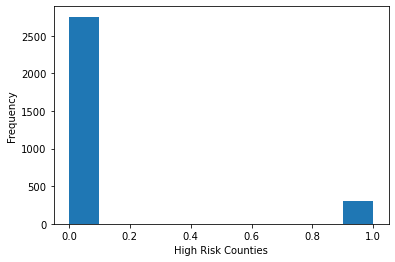

In [76]:
# frequency histogram to see how many counties are high risk and low risk
plt.hist(df["case_class_high"])
plt.xlabel("High Risk Counties")
plt.ylabel("Frequency")
plt.show()

In [77]:
#split data for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2 ,random_state= 42) 

In [78]:
# Determine the shape of our training and testing sets.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2446, 102)
(612, 102)
(2446,)
(612,)


In [79]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [80]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 25, random_state= 42)

RandomForestRegressor(n_estimators=25, random_state=42)

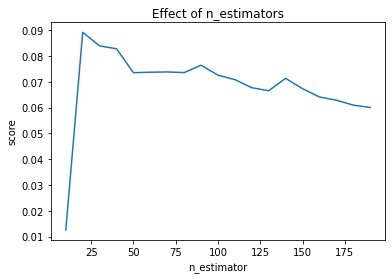

In [72]:
# Try different numbers of n_estimators 
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    regressor.set_params(n_estimators=n)
    regressor.fit(X_train, y_train)
    scores.append(regressor.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [86]:
regressor = regressor.fit(X_train_scaled, y_train)

In [87]:
# Making predictions using the testing data.
predictions = regressor.predict(X_test_scaled)
predictions

array([0.  , 0.  , 0.  , 0.32, 0.28, 0.36, 0.08, 0.  , 0.36, 0.16, 0.04,
       0.04, 0.08, 0.12, 0.28, 0.  , 0.  , 0.44, 0.04, 0.08, 0.04, 0.  ,
       0.28, 0.44, 0.48, 0.2 , 0.12, 0.04, 0.16, 0.  , 0.36, 0.32, 0.12,
       0.16, 0.  , 0.04, 0.28, 0.  , 0.04, 0.  , 0.16, 0.  , 0.08, 0.  ,
       0.04, 0.04, 0.  , 0.04, 0.12, 0.  , 0.32, 0.04, 0.  , 0.2 , 0.04,
       0.08, 0.24, 0.12, 0.  , 0.32, 0.  , 0.36, 0.  , 0.56, 0.  , 0.  ,
       0.  , 0.04, 0.04, 0.08, 0.16, 0.  , 0.  , 0.2 , 0.  , 0.24, 0.  ,
       0.04, 0.04, 0.16, 0.04, 0.2 , 0.32, 0.12, 0.24, 0.28, 0.2 , 0.  ,
       0.04, 0.08, 0.2 , 0.12, 0.04, 0.16, 0.4 , 0.04, 0.2 , 0.16, 0.2 ,
       0.  , 0.04, 0.  , 0.  , 0.04, 0.  , 0.  , 0.  , 0.12, 0.08, 0.4 ,
       0.4 , 0.  , 0.16, 0.08, 0.  , 0.  , 0.24, 0.2 , 0.08, 0.12, 0.  ,
       0.04, 0.24, 0.  , 0.28, 0.2 , 0.36, 0.04, 0.04, 0.04, 0.08, 0.12,
       0.16, 0.16, 0.24, 0.  , 0.24, 0.04, 0.  , 0.28, 0.  , 0.  , 0.16,
       0.  , 0.  , 0.24, 0.04, 0.04, 0.  , 0.08, 0.

In [82]:
#mean squared error
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, predictions)

0.08334117647058824

In [83]:
# root mean squared error
np.sqrt(mean_squared_error(y_test, predictions))

0.2886887189874039

In [84]:
# mean absolute error
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error", metrics.mean_absolute_error(y_test, predictions))

Mean Absolute Error 0.1704575163398693


In [85]:
# accuracy score
acc = regressor.score(X_test, y_test)
print((acc)*100)

-122.9474721407625
